Class names: ['angry', 'happy', 'relaxed', 'sad']
Number of classes: 4

--- Training Set Distribution ---
angry: 700 images
happy: 700 images
relaxed: 700 images
sad: 700 images

--- Validation Set Distribution ---
angry: 100 images
happy: 100 images
relaxed: 100 images
sad: 100 images

--- Test Set Distribution ---
angry: 200 images
happy: 200 images
relaxed: 200 images
sad: 200 images


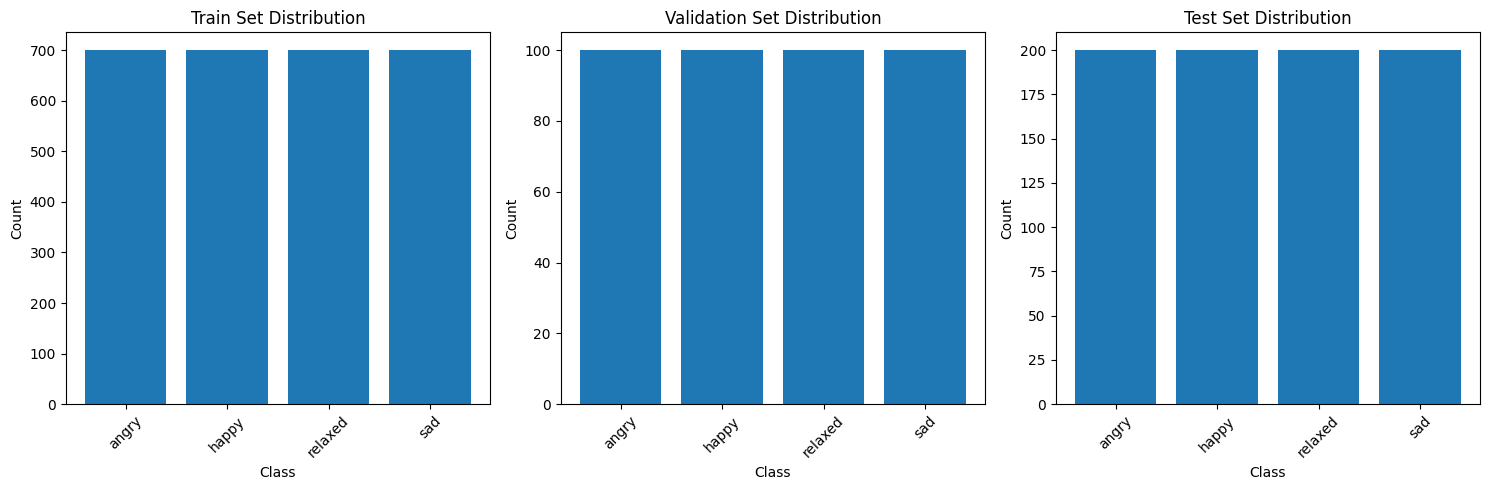

Mean RGB: [121.04671064 113.02207085  99.08456767]
Median RGB: [121. 110.  88.]
Average width: 417.3042857142857
Average height: 389.4764285714286
STD RGB: [69.73555086 67.90898156 68.16562738]


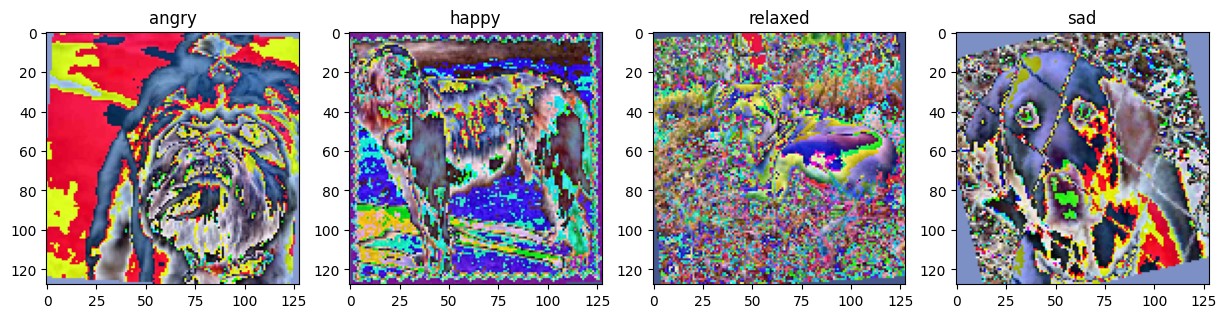

Epoch [1/50] Train Loss: 1.4388, Train Acc: 29.89% | Val Loss: 1.3170, Val Acc: 36.25%
Epoch [2/50] Train Loss: 1.3379, Train Acc: 34.61% | Val Loss: 1.3063, Val Acc: 40.00%
Epoch [3/50] Train Loss: 1.3077, Train Acc: 37.43% | Val Loss: 1.2773, Val Acc: 38.75%
Epoch [4/50] Train Loss: 1.2810, Train Acc: 40.32% | Val Loss: 1.2888, Val Acc: 40.25%
Epoch [5/50] Train Loss: 1.2545, Train Acc: 40.79% | Val Loss: 1.2486, Val Acc: 40.50%
Epoch [6/50] Train Loss: 1.2406, Train Acc: 43.71% | Val Loss: 1.2589, Val Acc: 41.50%
Epoch [7/50] Train Loss: 1.2189, Train Acc: 44.04% | Val Loss: 1.2482, Val Acc: 44.50%
Epoch [8/50] Train Loss: 1.2273, Train Acc: 42.50% | Val Loss: 1.2338, Val Acc: 46.25%
Epoch [9/50] Train Loss: 1.1871, Train Acc: 45.46% | Val Loss: 1.2589, Val Acc: 43.00%
Epoch [10/50] Train Loss: 1.1794, Train Acc: 44.82% | Val Loss: 1.2303, Val Acc: 44.75%
Epoch [11/50] Train Loss: 1.1676, Train Acc: 47.43% | Val Loss: 1.2045, Val Acc: 46.50%
Epoch [12/50] Train Loss: 1.1559, Train A

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# EDA: Load dataset and check label distribution
data_dir = 'hw1_data/dog_emotion'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Load the datasets without transformations for EDA
train_dataset_eda = dsets.ImageFolder(root=train_dir)
val_dataset_eda = dsets.ImageFolder(root=val_dir)
test_dataset_eda = dsets.ImageFolder(root=test_dir)

classes = train_dataset_eda.classes
num_classes = len(classes)

# Extract label lists
train_labels = [label for _, label in train_dataset_eda]
val_labels = [label for _, label in val_dataset_eda]
test_labels = [label for _, label in test_dataset_eda]

# Calculate label counts
train_counts = np.bincount(train_labels)
val_counts = np.bincount(val_labels)
test_counts = np.bincount(test_labels)

# Print distribution counts
print("Class names:", classes)
print("Number of classes:", num_classes)

print("\n--- Training Set Distribution ---")
for i, c in enumerate(classes):
    print(f"{c}: {train_counts[i]} images")

print("\n--- Validation Set Distribution ---")
for i, c in enumerate(classes):
    print(f"{c}: {val_counts[i]} images")

print("\n--- Test Set Distribution ---")
for i, c in enumerate(classes):
    print(f"{c}: {test_counts[i]} images")

# Plot distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].bar(range(num_classes), train_counts, tick_label=classes)
ax[0].set_title("Train Set Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Count")
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(range(num_classes), val_counts, tick_label=classes)
ax[1].set_title("Validation Set Distribution")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Count")
ax[1].tick_params(axis='x', rotation=45)

ax[2].bar(range(num_classes), test_counts, tick_label=classes)
ax[2].set_title("Test Set Distribution")
ax[2].set_xlabel("Class")
ax[2].set_ylabel("Count")
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
# Calculate mean, median, and size from a subset or all training images
# For large datasets, consider a subset for efficiency, but here we can attempt all if it's not too large.

all_pixels = []
widths = []
heights = []

for img_path, _ in train_dataset_eda.imgs:
    img = Image.open(img_path).convert('RGB')
    # Collect sizes
    w, h = img.size
    widths.append(w)
    heights.append(h)
    # Convert to numpy for mean calculation
    img_np = np.array(img)
    # reshape to (H*W, C)
    pixels = img_np.reshape(-1, 3)
    all_pixels.append(pixels)

all_pixels = np.vstack(all_pixels)  # shape: (total_pixels, 3)

mean_rgb = np.mean(all_pixels, axis=0)   # mean per channel
median_rgb = np.median(all_pixels, axis=0)  # median per channel

mean_width = np.mean(widths)
mean_height = np.mean(heights)

print("Mean RGB:", mean_rgb)
print("Median RGB:", median_rgb)
print("Average width:", mean_width)
print("Average height:", mean_height)
std_rgb = np.std(all_pixels, axis=0)
print("STD RGB:", std_rgb)
# Compute normalized mean/std in [0,1]
norm_mean = mean_rgb / 255.0
norm_std = std_rgb / 255.0

# Define transforms
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

transform_valtest = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

train_dataset = dsets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = dsets.ImageFolder(root=val_dir, transform=transform_valtest)
test_dataset = dsets.ImageFolder(root=test_dir, transform=transform_valtest)

# print a sample from each class
label_to_name = {0: 'angry', 1: 'happy', 2: 'relaxed', 3: 'sad'}

labels_seen = []
transform_to_pil = transforms.ToPILImage()

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for image, label in train_dataset:
    if label not in labels_seen:
        labels_seen.append(label)
        image = transform_to_pil(image)
        axs[len(labels_seen) - 1].imshow(image)
        axs[len(labels_seen) - 1].set_title(label_to_name[label])
    if len(labels_seen) == 4:
        break

plt.show()
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Calculate flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 128, 128)
            f = self.features(dummy)
            flattened_size = f.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x  # raw logits
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=70):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            total_train += labels.size(0)

        train_epoch_loss = running_loss / total_train
        train_epoch_acc = 100.0 * correct_train / total_train
        train_loss_history.append(train_epoch_loss)
        train_acc_history.append(train_epoch_acc)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                correct_val += predicted.eq(labels).sum().item()
                total_val += labels.size(0)

        val_epoch_loss = running_val_loss / total_val
        val_epoch_acc = 100.0 * correct_val / total_val
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.2f}% | "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")

        # Save best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), "best_model.pth")

    return {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history,
        'best_val_acc': best_val_acc
    }

num_epochs = 50
history = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)



Device: cpu
Classes: ['angry', 'happy', 'relaxed', 'sad']


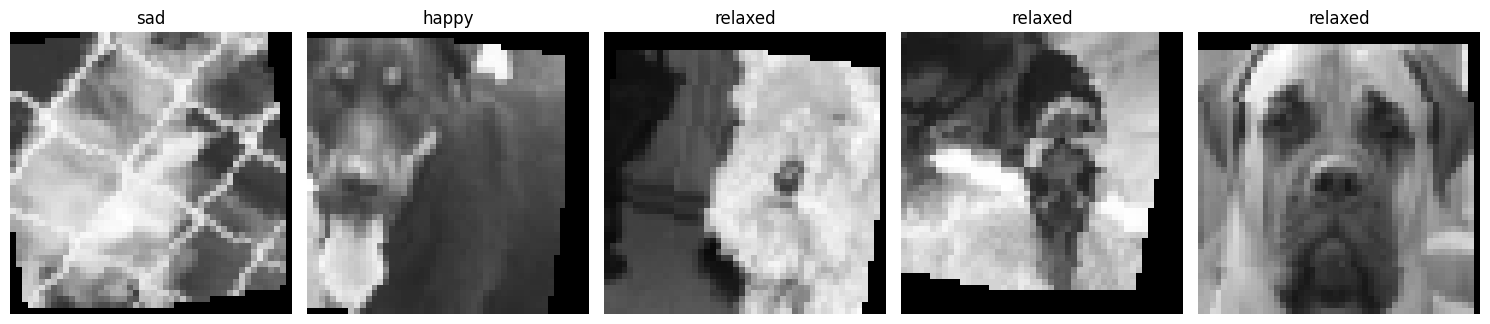

SmallCNN()


ValueError: optimizer got an empty parameter list

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

#######################################
# Visualize Images Before and After Transformations
#######################################
def visualize_transformations(dataset, num_images=5, title=""):
    fig, axs = plt.subplots(2, num_images, figsize=(15, 6))
    for i in range(num_images):
        original_img, label = dataset[i]
        axs[0, i].imshow(original_img.permute(1, 2, 0))
        axs[0, i].set_title(f"Original: {class_names[label]}")
        axs[0, i].axis("off")

        transformed_img, label = dataset[i]
        axs[1, i].imshow(transformed_img.permute(1, 2, 0).numpy())
        axs[1, i].set_title(f"Transformed: {class_names[label]}")
        axs[1, i].axis("off")
    fig.suptitle(title, fontsize=16)
    plt.show()

#######################################
# Data Paths and Setup
#######################################
data_dir = "hw1_data/dog_emotion"
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

#######################################
# Adjusted Transformations
#######################################
train_transforms = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize for RGB channels
                         std=[0.229, 0.224, 0.225])   # Standard deviation for RGB
])

val_test_transforms = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize for RGB channels
                         std=[0.229, 0.224, 0.225])   # Standard deviation for RGB
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=val_test_transforms)

class_names = train_dataset.classes
num_classes = len(class_names)

# Visualize transformed images
visualize_transformations(torchvision.datasets.ImageFolder(train_dir, transform=transforms.ToTensor()), title="Before Transformations")
visualize_transformations(train_dataset, title="After Transformations")

#######################################
# Model Definition
#######################################
class DropoutL2RegularizedCNN(nn.Module):
    def _init_(self, num_classes=5):
        super(DropoutL2RegularizedCNN, self)._init_()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # New layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Dropout(p=0.4)  # Random dropout layer
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 3, 48, 48)
            flattened_size = self.features(dummy).view(1, -1).size(1)

        self.classifier = nn.Sequential(
        nn.Linear(flattened_size, 512),
        nn.ReLU(),
        nn.Dropout(p=0.6),  # Increased dropout
        nn.Linear(512, num_classes)
    )


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

#######################################
# Model, Loss, Optimizer Setup
#######################################
batch_size = 256  # Updated batch size
base_batch_size = 256  # Reference batch size for scaling
base_learning_rate = 0.01
scaled_learning_rate = base_learning_rate * (batch_size / base_batch_size)  # Scaled learning rate

model = DropoutL2RegularizedCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=scaled_learning_rate, momentum=0.9, weight_decay=1e-4)  # L2 Regularization

#######################################
# Data Loaders
#######################################
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#######################################
# Training Loop
#######################################
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

epochs = 200  # Reduced number of epochs
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct_train += predicted.eq(labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_train_loss / total_train
    train_acc = 100. * correct_train / total_train
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_acc)

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = total_val_loss / total_val
    val_acc = 100. * correct_val / total_val
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_train_loss:.4f}  Train Acc: {train_acc:.2f}%  "
          f"Val Loss: {avg_val_loss:.4f}  Val Acc: {val_acc:.2f}%")

#######################################
# Evaluate on Test Set
#######################################
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct_test += predicted.eq(labels).sum().item()
        total_test += labels.size(0)

test_acc = 100. * correct_test / total_test
print(f"Test Accuracy: {test_acc:.2f}%")

#######################################
# Plot Results
#######################################
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_acc_history, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()